# 🩺 GenECG Inference Demo

**Feed an ECG image → Get SNOMED-CT diagnostic codes**

This notebook uses your trained ViT model to predict diagnoses.

---

In [1]:
# Setup
!pip install -q transformers torch torchvision pillow

from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_ROOT = "/content/drive/Othercomputers/My_MacBook_Air/GenECG-Diagnostic"
os.chdir(PROJECT_ROOT)
print(f"✅ Working directory: {os.getcwd()}")

Mounted at /content/drive
✅ Working directory: /content/drive/Othercomputers/My_MacBook_Air/GenECG-Diagnostic


In [2]:
import torch
from transformers import ViTForImageClassification
from PIL import Image
from torchvision import transforms
from pathlib import Path

# Load trained model
print("📦 Loading ViT model...")
checkpoint = torch.load("runs/vit/vit_multilabel_checkpoint.pt", map_location='cpu')

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=checkpoint['num_classes'],
    ignore_mismatched_sizes=True,
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

snomed_cols = checkpoint['snomed_cols']
print(f"✅ Model loaded with {len(snomed_cols)} SNOMED classes")

📦 Loading ViT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([65, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded with 65 SNOMED classes


In [5]:
def predict_ecg(image_path, top_k=10, threshold=0.3):
    """Predict SNOMED-CT codes for an ECG image."""

    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load image
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)

    # Predict
    with torch.no_grad():
        logits = model(img_tensor).logits
        probs = torch.sigmoid(logits)[0].numpy()

    # Get top predictions
    top_indices = probs.argsort()[::-1][:top_k]

    print("="*60)
    print("📋 SNOMED-CT DIAGNOSTIC PREDICTIONS")
    print("="*60)
    print(f"{'SNOMED Code':<15} {'Probability':>12} {'Status':<12}")
    print("-"*60)

    positive_count = 0
    for idx in top_indices:
        code = snomed_cols[idx].replace('SNOMED_', '')
        prob = probs[idx]
        status = "🔴 POSITIVE" if prob >= threshold else ""
        if prob >= threshold:
            positive_count += 1
        print(f"{code:<15} {prob:>11.1%} {status:<12}")

    print("-"*60)
    print(f"\n📊 Summary: {positive_count} diagnoses above {threshold:.0%} threshold")

    return probs

data		 GEMINI.md  requirements.txt  yolo11n.pt
data_A.yaml	 notebooks  runs	      yolov8n.pt
data_colab.yaml  README.md  src


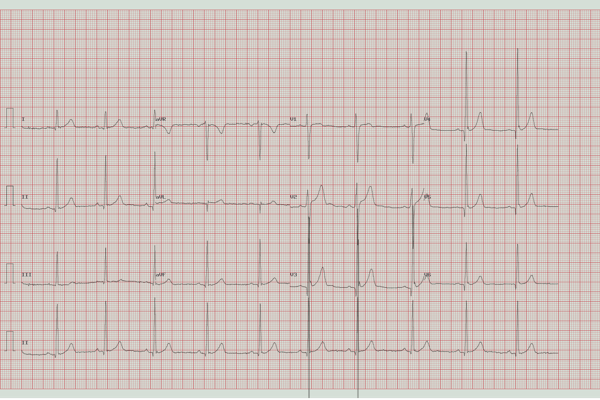

📋 SNOMED-CT DIAGNOSTIC PREDICTIONS
SNOMED Code      Probability Status      
------------------------------------------------------------
4065279               70.6% 🔴 POSITIVE  
4102533               22.1%             
4184746               19.6%             
4186397               19.3%             
4064346               11.7%             
4329847                5.6%             
4247796                5.2%             
4089462                4.2%             
4065390                4.1%             
4137208                3.9%             
------------------------------------------------------------

📊 Summary: 1 diagnoses above 30% threshold


In [12]:
# 🔍 TEST ON A SAMPLE IMAGE
# Change this path to test different images!
!ls
test_image = "data/Raw/GenECG/Dataset_A_ECGs_without_imperfections/images/00085_hr_1R.png"

# Show the image
from IPython.display import display
img = Image.open(test_image)
display(img.resize((600, 400)))

# Predict!
probs = predict_ecg(test_image, top_k=10, threshold=0.3)

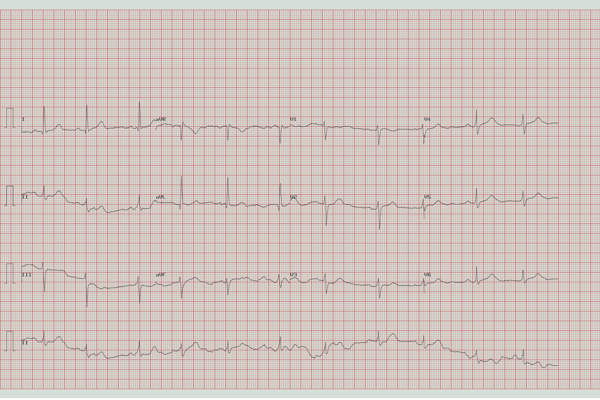

📋 SNOMED-CT DIAGNOSTIC PREDICTIONS
SNOMED Code      Probability Status      
------------------------------------------------------------
4329847               44.1% 🔴 POSITIVE  
4247796               28.4%             
40482086              11.4%             
4064610               10.2%             
4295336                9.7%             
4065279                8.8%             
4065390                7.3%             
4064461                7.2%             
4102533                5.5%             
37017194               4.9%             
------------------------------------------------------------

📊 Summary: 1 diagnoses above 30% threshold


In [14]:
# 🔍 TEST ON ANOTHER IMAGE
test_image2 = "data/Raw/GenECG/Dataset_A_ECGs_without_imperfections/images/00050_hr_1R.png"

img = Image.open(test_image2)
display(img.resize((600, 400)))

probs = predict_ecg(test_image2, top_k=10, threshold=0.3)

📤 Upload an ECG image to analyze:


Saving 00228_hr_1R.png to 00228_hr_1R.png

🔍 Analyzing: 00228_hr_1R.png


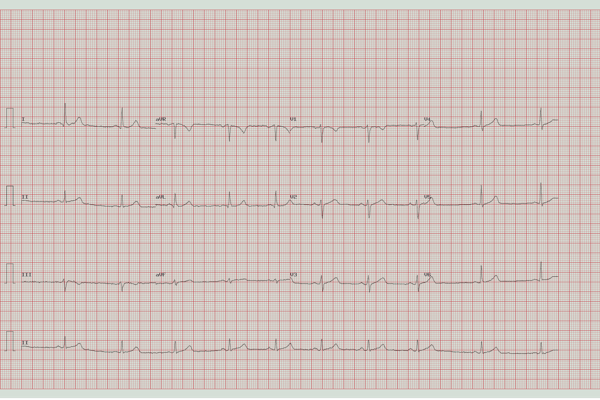

📋 SNOMED-CT DIAGNOSTIC PREDICTIONS
SNOMED Code      Probability Status      
------------------------------------------------------------
4065279               85.3% 🔴 POSITIVE  
4065390                6.9%             
4329847                4.4%             
4247796                3.9%             
4088338                2.0%             
37017193               1.9%             
4327859                1.9%             
4186397                1.8%             
4064461                1.8%             
4064610                1.8%             
------------------------------------------------------------

📊 Summary: 1 diagnoses above 30% threshold


In [15]:
# 📤 UPLOAD YOUR OWN ECG IMAGE
from google.colab import files

print("📤 Upload an ECG image to analyze:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n🔍 Analyzing: {filename}")
    img = Image.open(filename)
    display(img.resize((600, 400)))
    probs = predict_ecg(filename, top_k=10, threshold=0.3)

---
## 📋 SNOMED-CT Code Reference

The model predicts from 65 diagnostic codes. Example codes:
- **4065279** - Normal ECG
- **4247796** - Sinus rhythm
- **4329847** - Atrial fibrillation
- etc.

Look up full descriptions at: https://browser.ihtsdotools.org/